In [3]:
from utils.binaries import *
from utils.plotting import *

IDs = {
    "NuriaJr": 56,
    "Peru": 1737,
    "Granada": 1738,
    "Jaco": 1742,
    "LeQuiDon": 1744,
    "Svenja": 1733,
    "Nadia": 1723,
    "USA": 1251,
    "Vegetta": 1732,
    "Virginia": 699,
    "Constanza": 734,
    "Lucho": 972,
}


def get_vem_approximate(station: str, date: str, plot: bool = False) -> np.ndarray:

    from datetime import datetime
    from datetime import timedelta
    from scipy.stats import zscore
    from utils.Auger.SD import Monitoring

    try:
        t_begin, t_end = np.loadtxt(
            f"/cr/tempdata01/filip/UubRandoms/{date}/converted/timestamps/{station}.dat",
            unpack=True,
            usecols=[1, 2],
        )
        DAQ_begin, DAQ_end = datetime.fromtimestamp(
            np.min(t_begin)
        ), datetime.fromtimestamp(np.max(t_end))

    except FileNotFoundError:
        print("Error! Requested dataset does not exist!")
        return None

    YYYY, MM, DD1 = [
        (DAQ_begin - timedelta(days=1)).__getattribute__(x)
        for x in ["year", "month", "day"]
    ]
    DD2 = (DAQ_end + timedelta(days=3)).day  # add 2 days since range is [low, high)

    M = Monitoring.Monit(YYYY, MM, range(DD1, DD2))
    t = M("fTime", IDs[station])
    p = M("fPeak", IDs[station])

    """because why the fuck should monitoring provide sequential data?"""
    sort = np.argsort(t)
    t, p = t[sort], p[sort]

    """remove outliers where something obviously went wrong"""
    mask = [np.all(point < 3) for point in np.abs(zscore(p))]  # 3 sigma cut = 99%
    t, p = t[mask], p[mask]

    cut_index = np.argmax(np.diff(t)) + 1
    vem_before, vem_after = p[:cut_index], p[cut_index:]
    average_before = np.mean(vem_before[-5:], axis=0)
    average_after = np.mean(vem_after[:5], axis=0)

    closest_to_start_DAQ = before = np.argmin(np.abs(t - datetime.timestamp(DAQ_begin)))
    closest_to_end_DAQ = after = np.argmin(np.abs(t - datetime.timestamp(DAQ_end)))
    closest_is_before_DAQ = t[closest_to_end_DAQ] > datetime.timestamp(DAQ_end)
    closest_is_after_DAQ = t[closest_to_start_DAQ] < datetime.timestamp(DAQ_begin)

    begin = average_before if closest_is_after_DAQ else average_after
    end = average_after if closest_is_before_DAQ else average_before
    vem_approximate = np.round(0.5 * (begin + end), 2)
    vem_peak = list(vem_approximate)
    M.logger.info(f"calculated {vem_peak = }")

    if plot:

        from tabulate import tabulate
        from utils.plotting import plt

        t_before, t_after = [datetime.fromtimestamp(x) for x in t[:cut_index]], [
            datetime.fromtimestamp(x) for x in t[cut_index:]
        ]

        table = []
        fluctuations_before = (
            np.std(vem_before, axis=0) / np.mean(vem_before, axis=0) * 100
        )
        jump = (vem_after[0] - vem_before[-1]) / vem_before[-1] * 100
        fluctuations_after = (
            np.std(vem_after, axis=0) / np.mean(vem_after, axis=0) * 100
        )

        for i, (fb, j, fa) in enumerate(
            zip(fluctuations_before, jump, fluctuations_after)
        ):
            table.append(
                [
                    f"PMT #{i}",
                    f"{fb:.2f}%",
                    f"{'+' if j>0 else ''}{j:.2f}%",
                    f"{fa:.2f}%",
                ]
            )
        print(f"\nStability characteristics for: {station} / {date}")
        print(tabulate(table, headers=["", "before", "jump", "after"], tablefmt="grid"))

        plt.axvline(DAQ_begin, c="gray", ls="--", zorder=10)
        plt.axvline(DAQ_end, c="gray", ls="--", zorder=10)

        # plt.title(station)

        plt.hlines(
            vem_approximate[0],
            xmin=DAQ_begin,
            xmax=DAQ_end,
            color="steelblue",
            ls="--",
            lw=0.7,
        )
        plt.hlines(
            vem_approximate[1],
            xmin=DAQ_begin,
            xmax=DAQ_end,
            color="orange",
            ls="--",
            lw=0.7,
        )
        plt.hlines(
            vem_approximate[2],
            xmin=DAQ_begin,
            xmax=DAQ_end,
            color="green",
            ls="--",
            lw=0.7,
        )

        plt.scatter(t_before, vem_before[:, 0], marker="x", c="steelblue")
        plt.scatter(t_after, vem_after[:, 0], marker="+", c="steelblue")
        plt.scatter(t_before, vem_before[:, 1], marker="x", c="orange")
        plt.scatter(t_after, vem_after[:, 1], marker="+", c="orange")
        plt.scatter(t_before, vem_before[:, 2], marker="x", c="green")
        plt.scatter(t_after, vem_after[:, 2], marker="+", c="green")

        ymin = plt.gca().get_ylim()
        print(ymin)
        plt.text(
            DAQ_begin + 0.5 * (DAQ_end - DAQ_begin),
            ymin[0] + 0.04 * (ymin[-1] - ymin[0]),
            "DAQ",
            #  rotation=90,
            horizontalalignment="center",
            verticalalignment="center",
            color="black",
            zorder=10,
        )

        plt.ylabel(r"$I^\mathrm{WCD}_\mathrm{rate}$ / $\mathrm{ADC}$")
        # plt.savefig(f'/cr/users/filip/plots/UubRandoms/{station}.png')

        every_nth = 2
        for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)

15:40:35 (  +17.8s) [DEBUG  ] -- font size set to 9.5
15:40:35 (    +2ms) [DEBUG  ] -- label size set to 13.0
15:40:35 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:40:35 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:40:35 (    +1ms) [DEBUG  ] -- usetex set to True
15:40:35 (    +4ms) [INFO   ] -- received 5 file(s) as input
15:40:37 (   +1.4s) [INFO   ] -- View monit keys with self.keys()
15:40:37 (  +175ms) [INFO   ] -- found 683 entries for key fTime and station #1733
15:40:37 (  +519ms) [INFO   ] -- found 683 entries for key fPeak and station #1733
15:40:37 (   +55ms) [INFO   ] -- calculated vem_peak = [163.8, 177.14, 157.1]



Stability characteristics for: Svenja / 2022_11
+--------+----------+--------+---------+
|        | before   | jump   | after   |
+========+==========+========+=========+
| PMT #0 | 0.56%    | +8.04% | 0.63%   |
+--------+----------+--------+---------+
| PMT #1 | 0.89%    | +7.63% | 2.13%   |
+--------+----------+--------+---------+
| PMT #2 | 1.39%    | +8.30% | 1.68%   |
+--------+----------+--------+---------+
(142.5500061035156, 187.65000610351564)


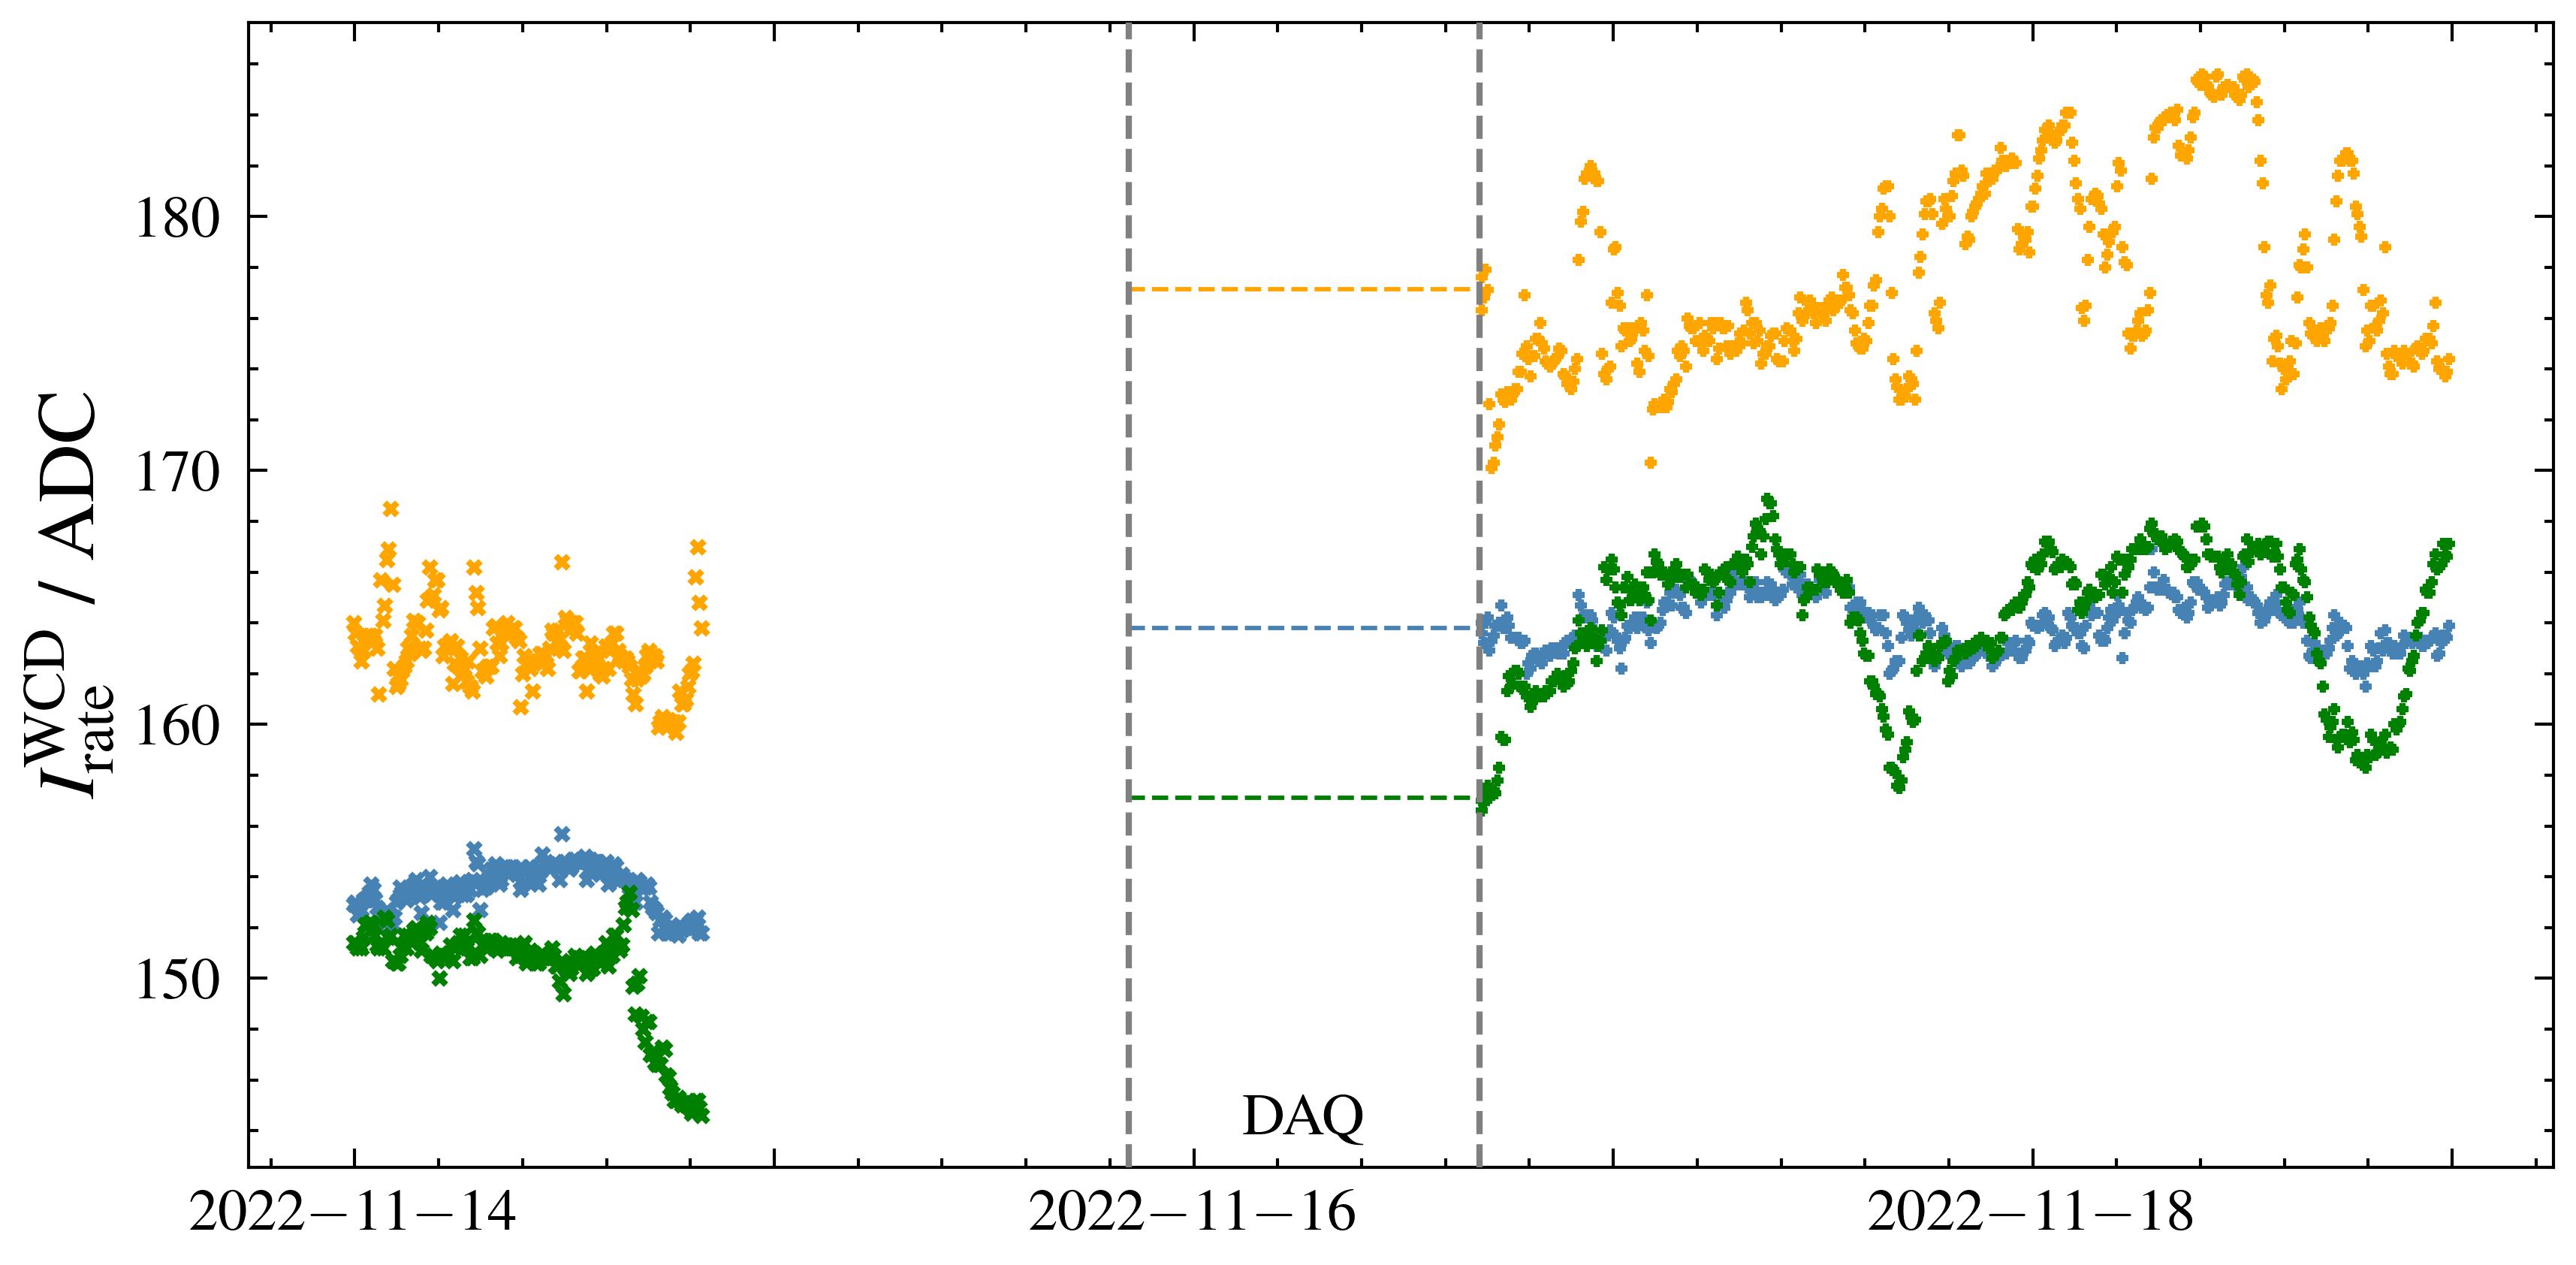

In [7]:
set_plt_style("single tex")

get_vem_approximate("Svenja", "2022_11", plot=True)
plot.save(path="malargue_2024_04/good_station")